<a href="https://colab.research.google.com/github/Zen0007/gan_with_mnis_tDataset/blob/main/gan_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [187]:
import numpy as np
import keras
import tensorflow as tf
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import *
from keras.layers import Activation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import os
from PIL import Image
plt.style.use("dark_background")

In [188]:
(trainX,trainY ), (testX,testY) = load_data()

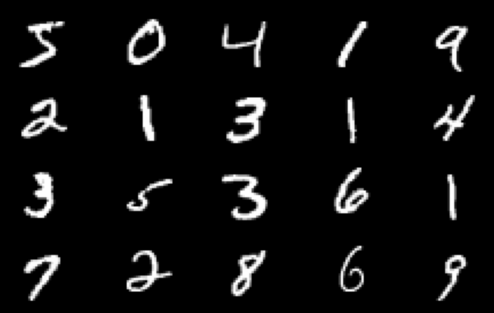

In [189]:
for i in range(20):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(trainX[i],cmap='gray')
plt.show()

In [190]:
Input_dim = 100
img_row = 28
img_cols = 28
channels = 1
img_shape = (img_row,img_cols,channels)

In [191]:
def generator():
  model = Sequential()
  model.add(Dense(128*7*7,input_dim=Input_dim))
  model.add(Reshape((7,7,128)))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
  model.add(Conv2D(1,(7,7),strides=(1,1),padding='same'))
  model.add(Activation('tanh'))
  model.summary()
  unit = Input(shape=(Input_dim,))
  img = model(unit)
  return Model(unit,img)

In [192]:
def distriminator():
  model = Sequential()
  model.add(Conv2D(32,kernel_size=3,strides=(2,2),padding='same',input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.01))

  model.add(Conv2D(64,kernel_size=3,strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dropout(0.35))

  model.add(Conv2D(128,kernel_size=3,strides=(2,2),padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(1,activation='sigmoid'))
  model.summary()
  img = Input(shape=img_shape)
  validation = model(img)
  return Model(img,validation)

In [193]:
opt = Adam(0.0002,0.5)

distriminator = distriminator()
distriminator.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

generator = generator()
i = Input(shape=(100,))
gan = generator(i)

distriminator.trainable =False

valid = distriminator(gan)
compile = Model(i,valid)
compile.compile(loss='binary_crossentropy',optimizer=opt)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_64 (Conv2D)          (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 dropout_32 (Dropout)        (None, 7, 7, 64)          0         
                                                                 
 conv2d_66 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 batch_normalization_49 (Bat  (None, 4, 4, 128)      

In [194]:
def save_imgs(epoch):
    row, colom = 4, 3
    noise = np.random.normal(0, 1, (row * colom, Input_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(row,
                            colom,
                            figsize=(12,12),
                            sharey=True,
                            sharex=True
                            )
    cnt = 0
    for i in range(row):
        for j in range(colom):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [195]:
def train(epochs,batch_size,save_inter):
  x_train = trainX / 127.5 - 1
  x_train = np.expand_dims(x_train,axis=3)
  valid = np.ones((batch_size,1))
  fake = np.zeros((batch_size,1))

  for epoch in range(epochs):
     idx = np.random.randint(0,x_train.shape[0],batch_size)
     real_data = x_train[idx]

     unit = np.random.normal(0,1,(batch_size,Input_dim))
     fake_data = generator.predict(unit)

     d_loss_real  = distriminator.train_on_batch(real_data,valid)
     d_loss_fake  = distriminator.train_on_batch(fake_data,fake)
     d_loss = 0.5*np.add(d_loss_real,d_loss_fake)

     g_loss = compile.train_on_batch(unit,valid)

     if epoch % save_inter == 0:
         print(f"epoch:{epoch}  D_loss{d_loss[0]}  Acc:{100*d_loss[1]}  G_loss:{g_loss} ")
         save_imgs(epoch)


4/4 [==============================] - 0s 6ms/step
epoch:0  D_loss0.5718315541744232  Acc:73.828125  G_loss:0.9385674595832825 
1/1 [==============================] - 0s 30ms/step


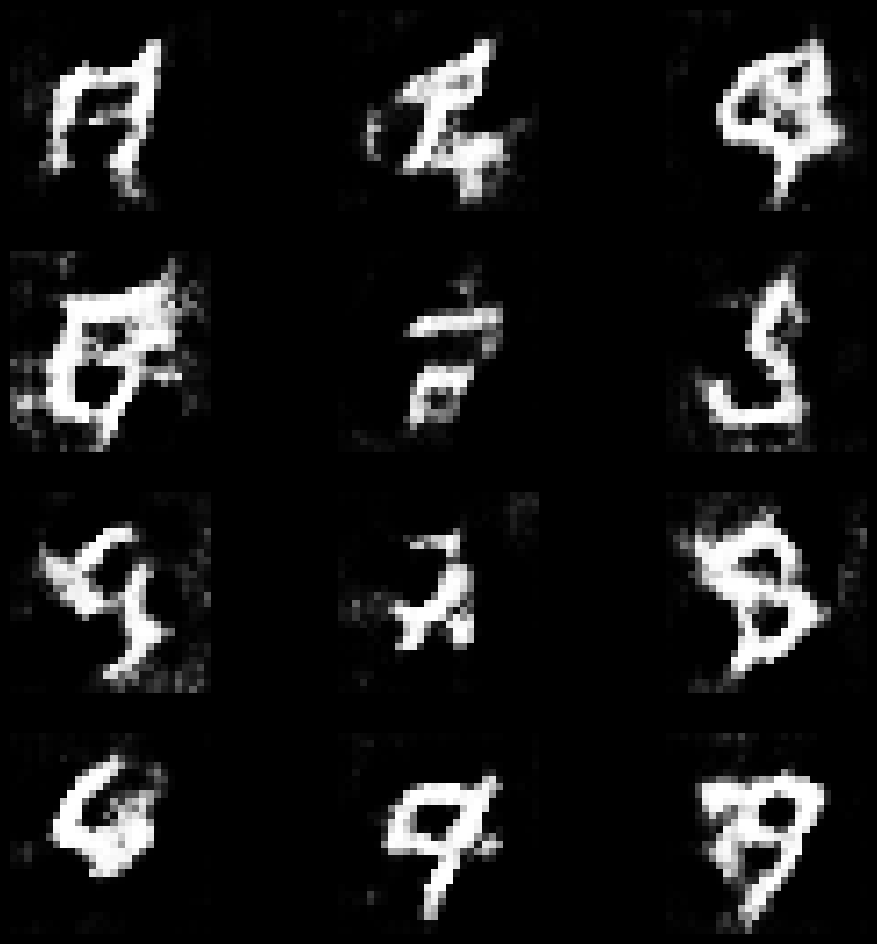

4/4 [==============================] - 0s 4ms/step
epoch:20  D_loss0.5769498944282532  Acc:72.65625  G_loss:0.8828401565551758 
1/1 [==============================] - 0s 17ms/step


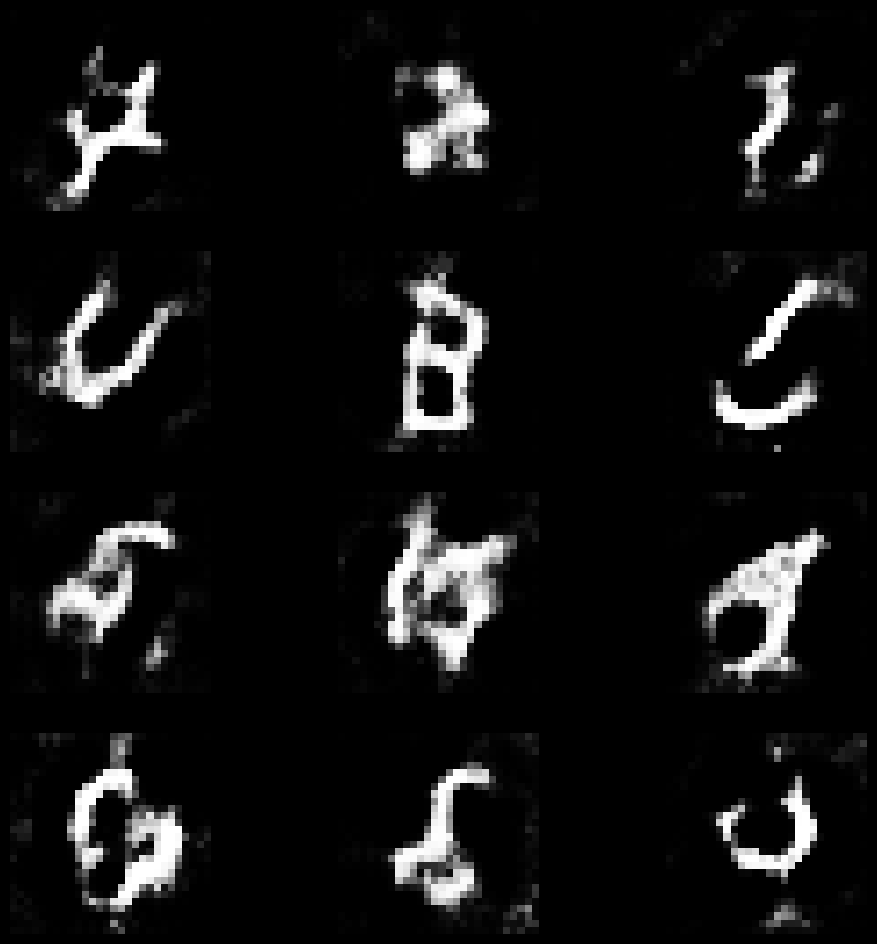

4/4 [==============================] - 0s 3ms/step
epoch:40  D_loss0.5654776692390442  Acc:73.4375  G_loss:0.8690654039382935 
1/1 [==============================] - 0s 17ms/step


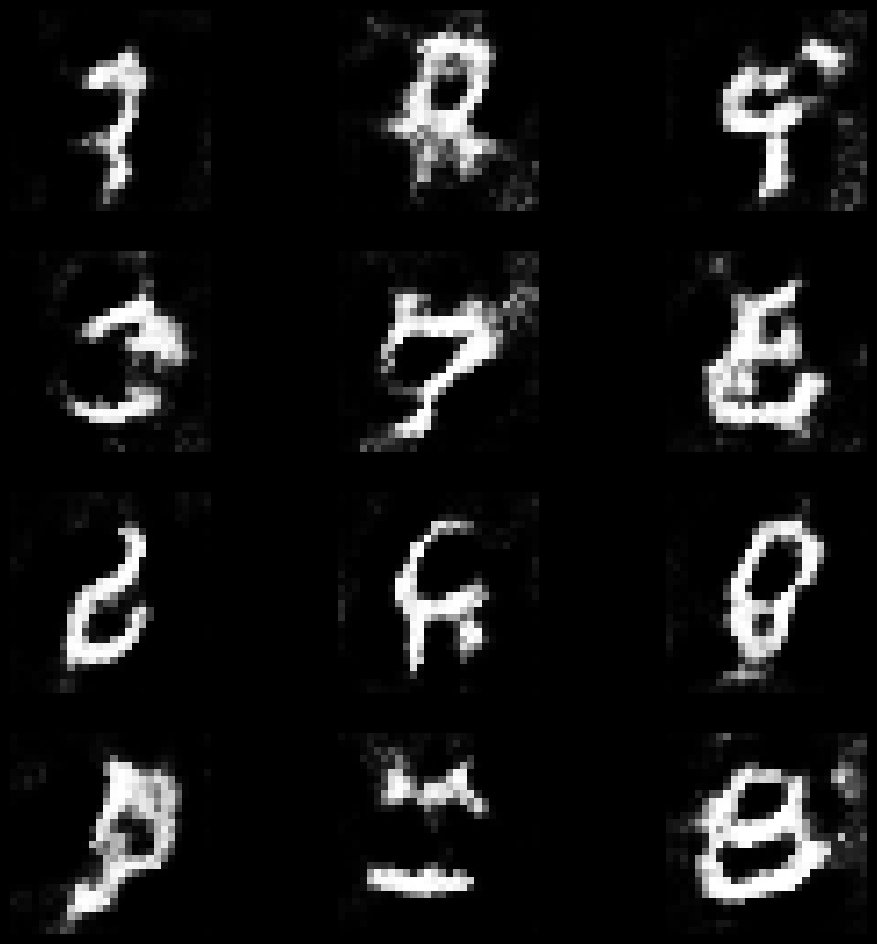

4/4 [==============================] - 0s 3ms/step
epoch:60  D_loss0.6187499463558197  Acc:66.796875  G_loss:0.8956441283226013 
1/1 [==============================] - 0s 16ms/step


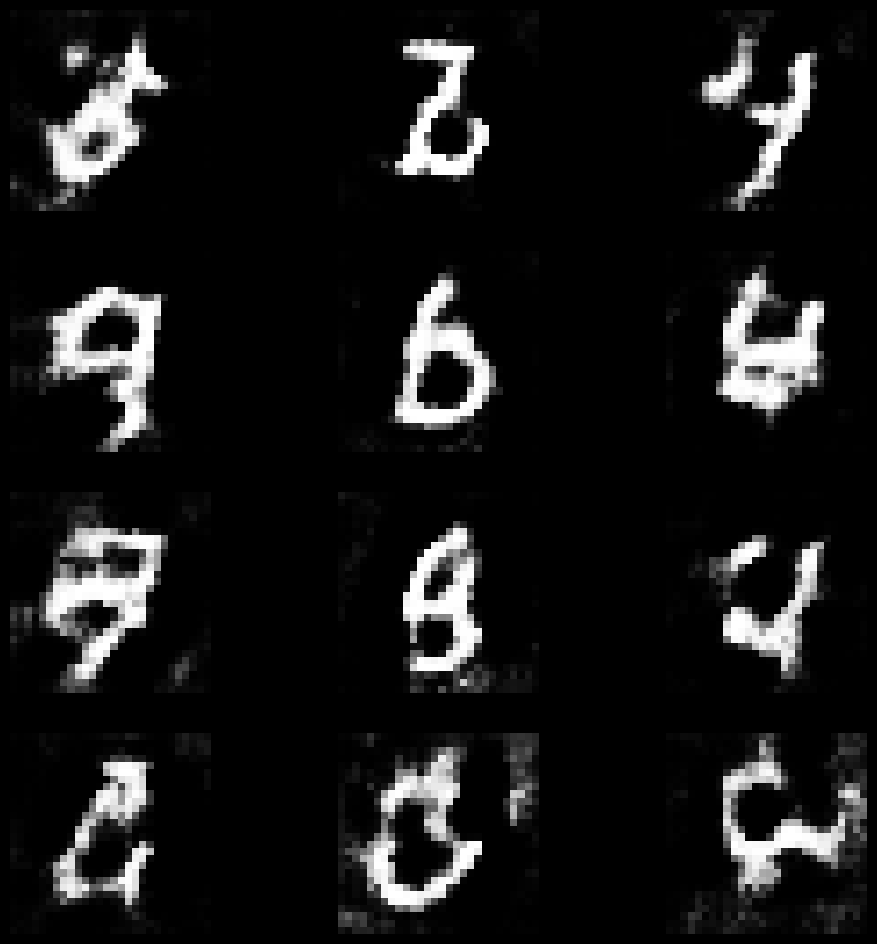

4/4 [==============================] - 0s 5ms/step
epoch:80  D_loss0.5831398069858551  Acc:70.3125  G_loss:0.8450323939323425 
1/1 [==============================] - 0s 25ms/step


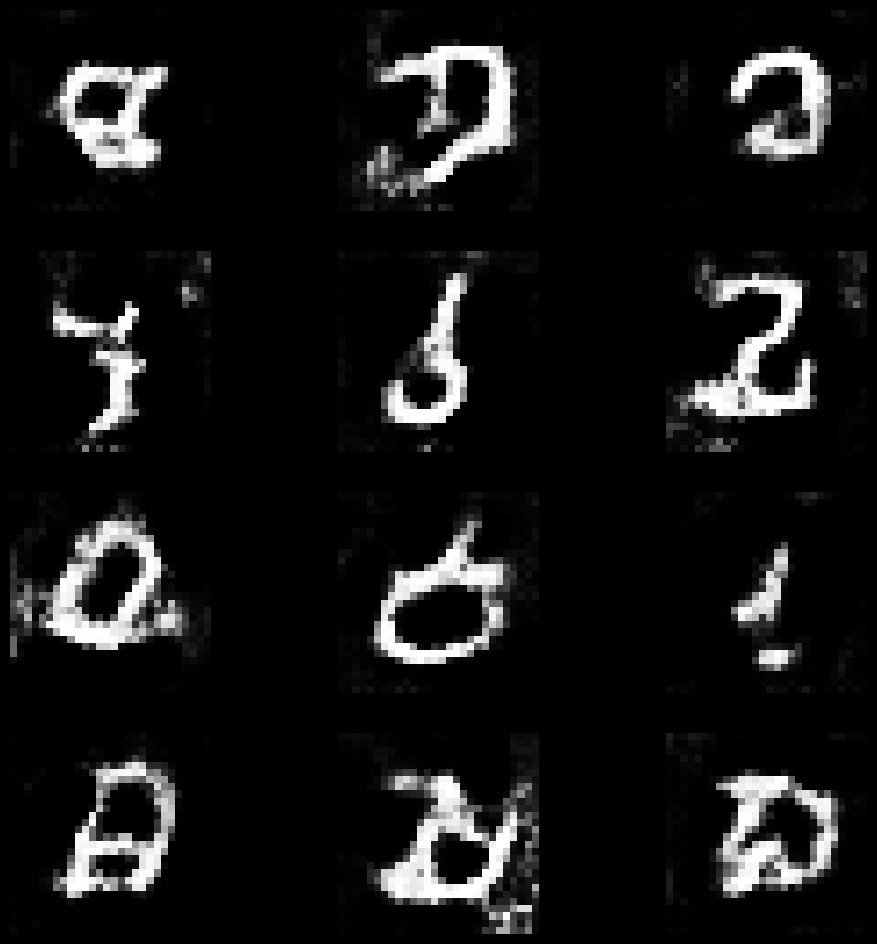

4/4 [==============================] - 0s 3ms/step
epoch:100  D_loss0.5742782354354858  Acc:75.0  G_loss:0.8716521859169006 
1/1 [==============================] - 0s 17ms/step


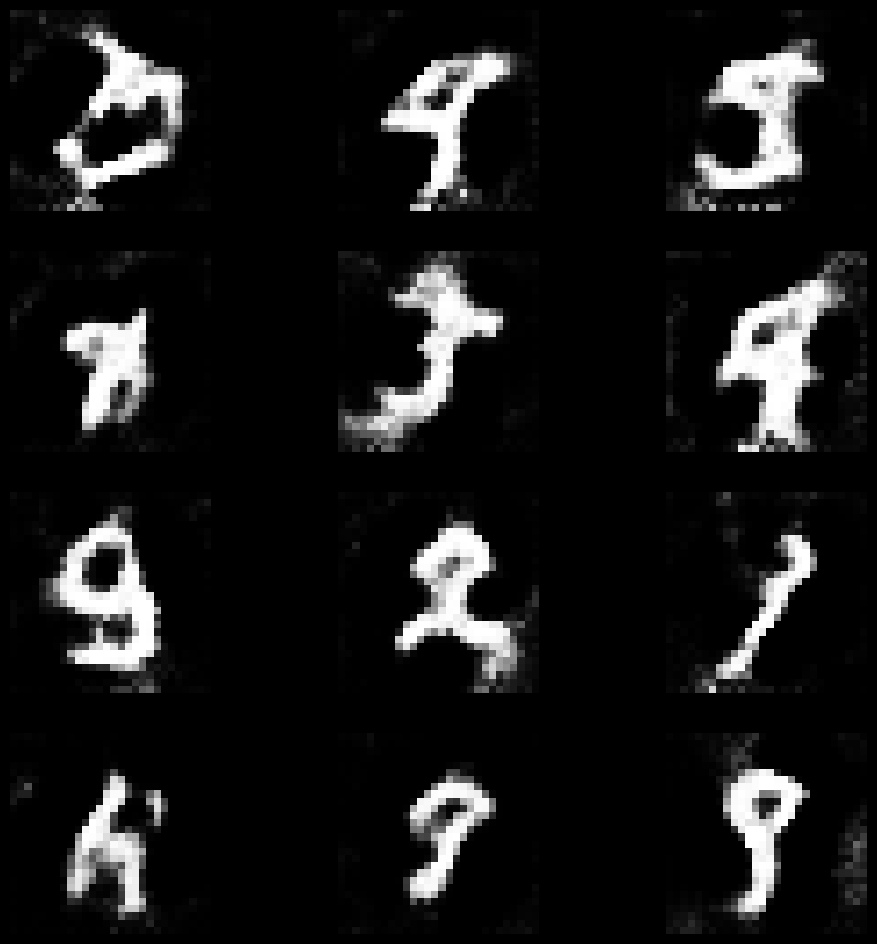

4/4 [==============================] - 0s 3ms/step
epoch:120  D_loss0.5412122309207916  Acc:77.34375  G_loss:0.8608614206314087 
1/1 [==============================] - 0s 17ms/step


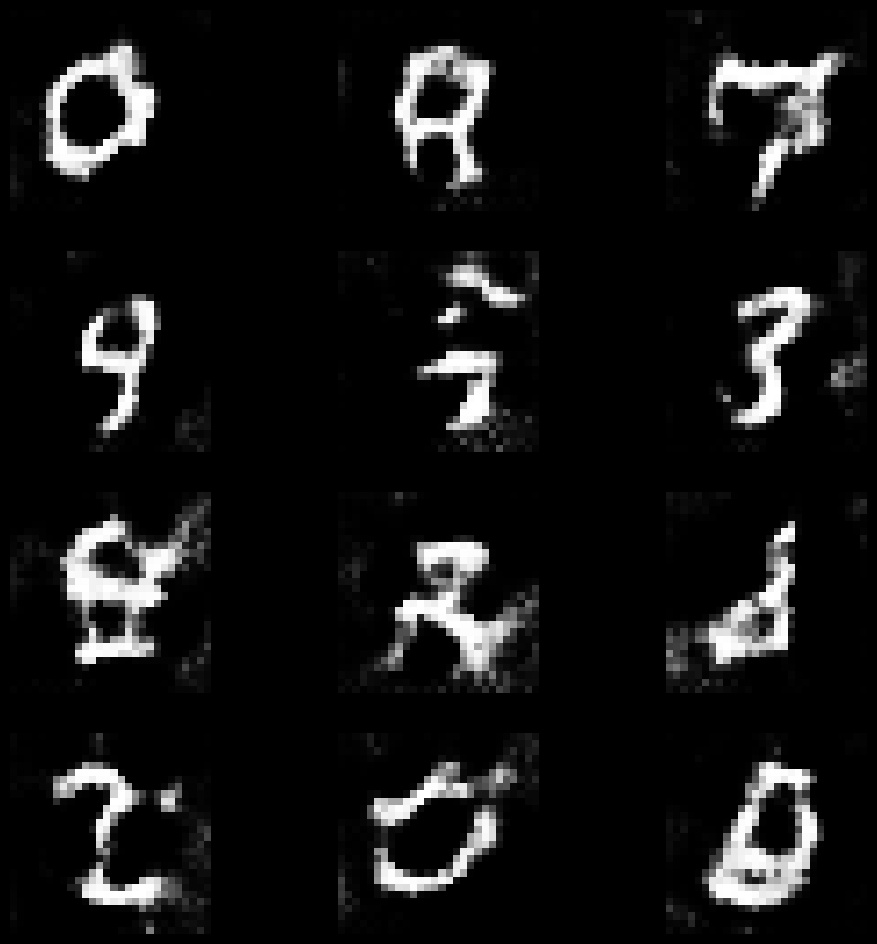

4/4 [==============================] - 0s 7ms/step
epoch:140  D_loss0.5609254837036133  Acc:76.953125  G_loss:0.8925067186355591 
1/1 [==============================] - 0s 27ms/step


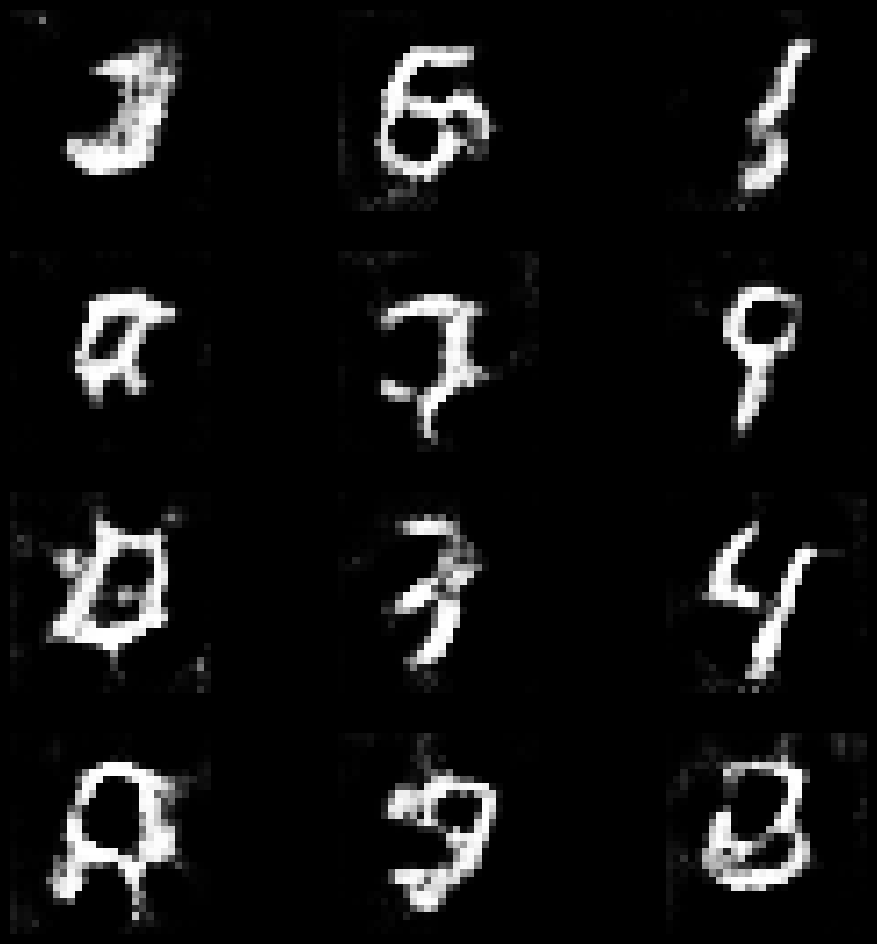

4/4 [==============================] - 0s 4ms/step
epoch:160  D_loss0.5706383883953094  Acc:75.390625  G_loss:0.8226765394210815 
1/1 [==============================] - 0s 18ms/step


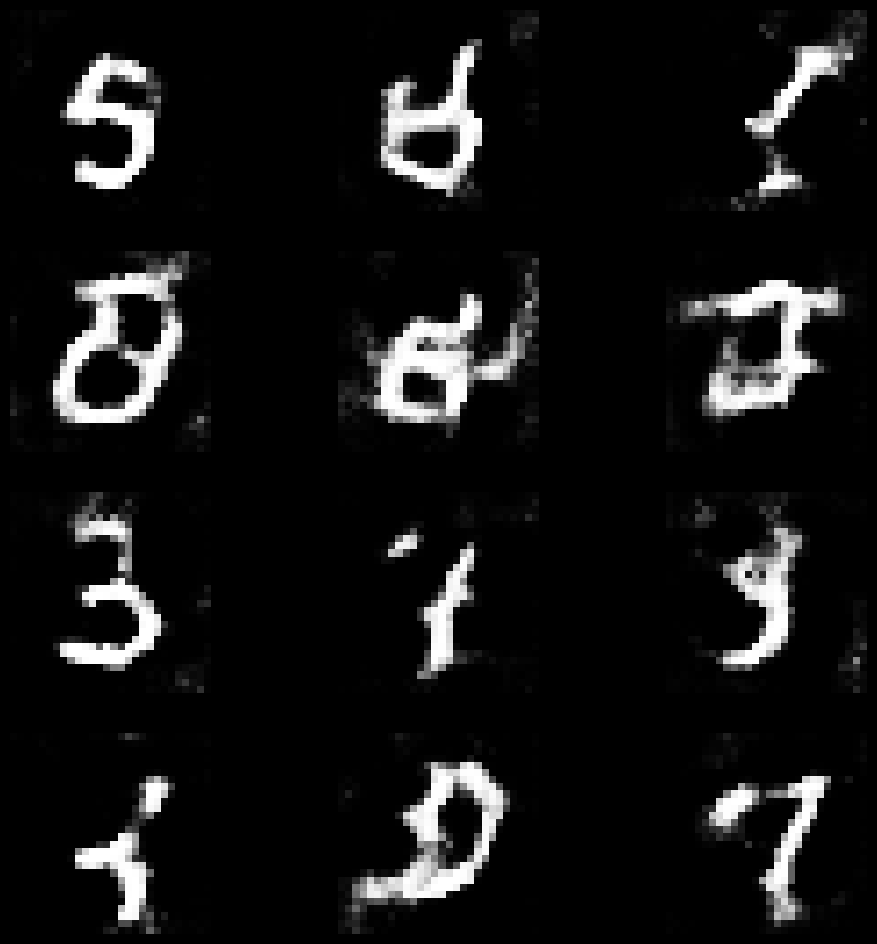

4/4 [==============================] - 0s 4ms/step
epoch:180  D_loss0.6666347682476044  Acc:60.9375  G_loss:0.8765573501586914 
1/1 [==============================] - 0s 19ms/step


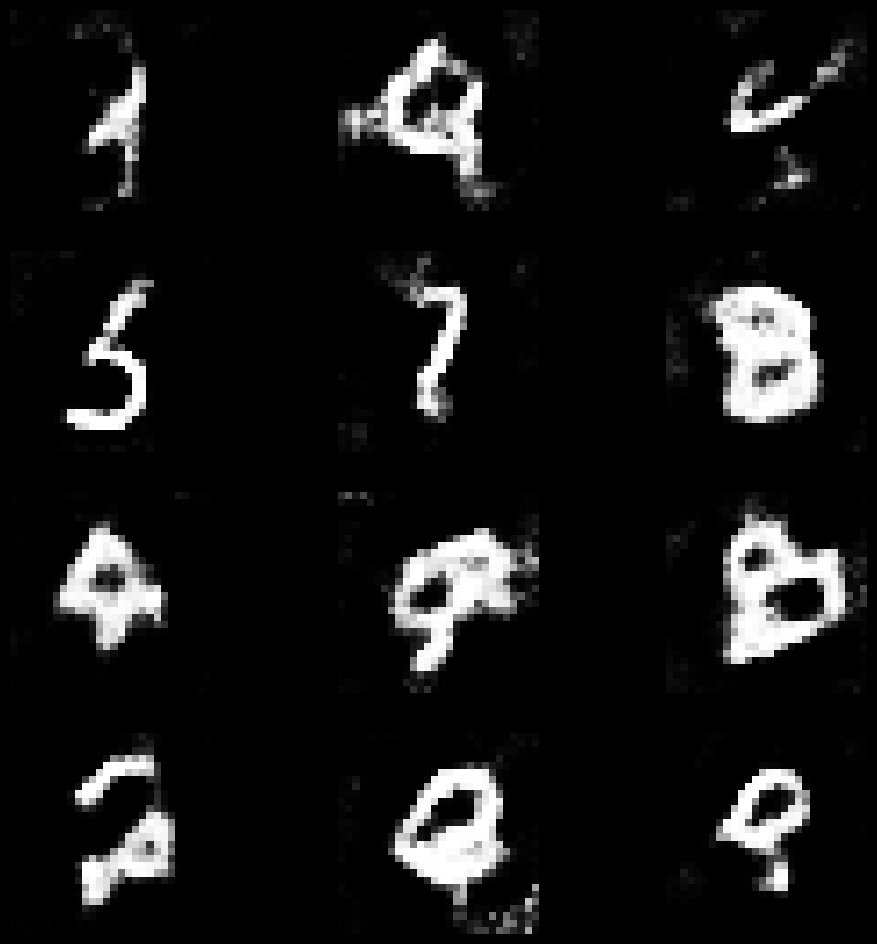

4/4 [==============================] - 0s 4ms/step
epoch:200  D_loss0.5816274285316467  Acc:72.65625  G_loss:0.9456143975257874 
1/1 [==============================] - 0s 34ms/step


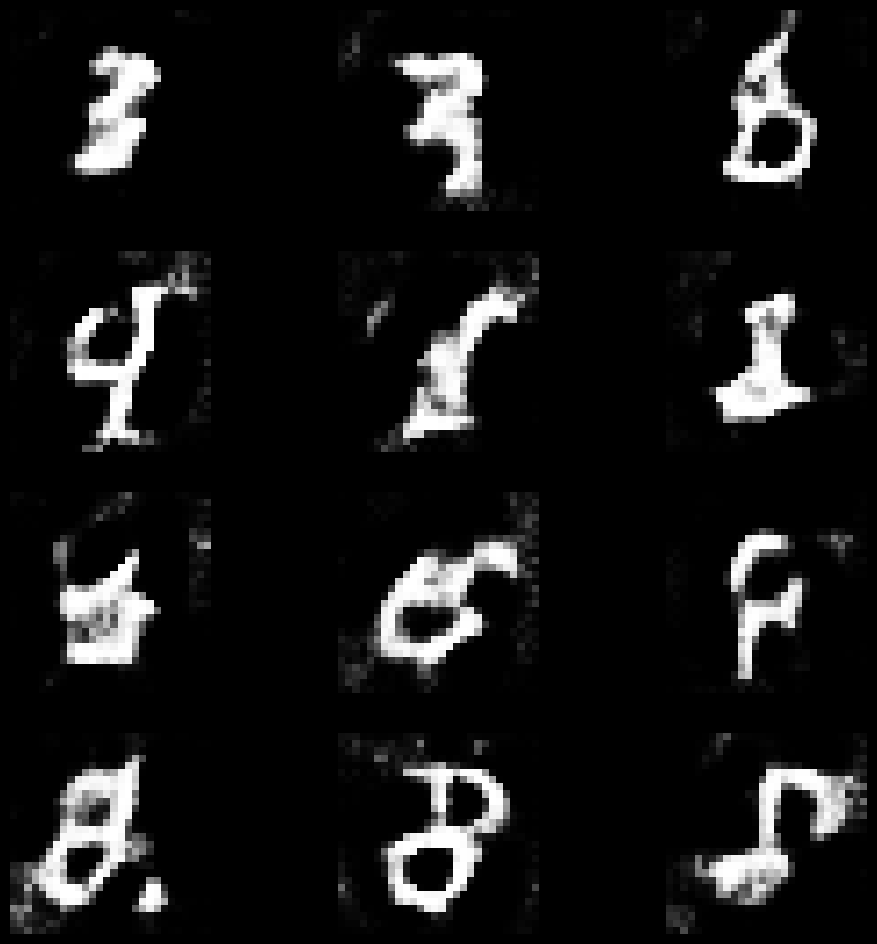

4/4 [==============================] - 0s 6ms/step
epoch:220  D_loss0.5566786229610443  Acc:73.828125  G_loss:0.8509795665740967 
1/1 [==============================] - 0s 19ms/step


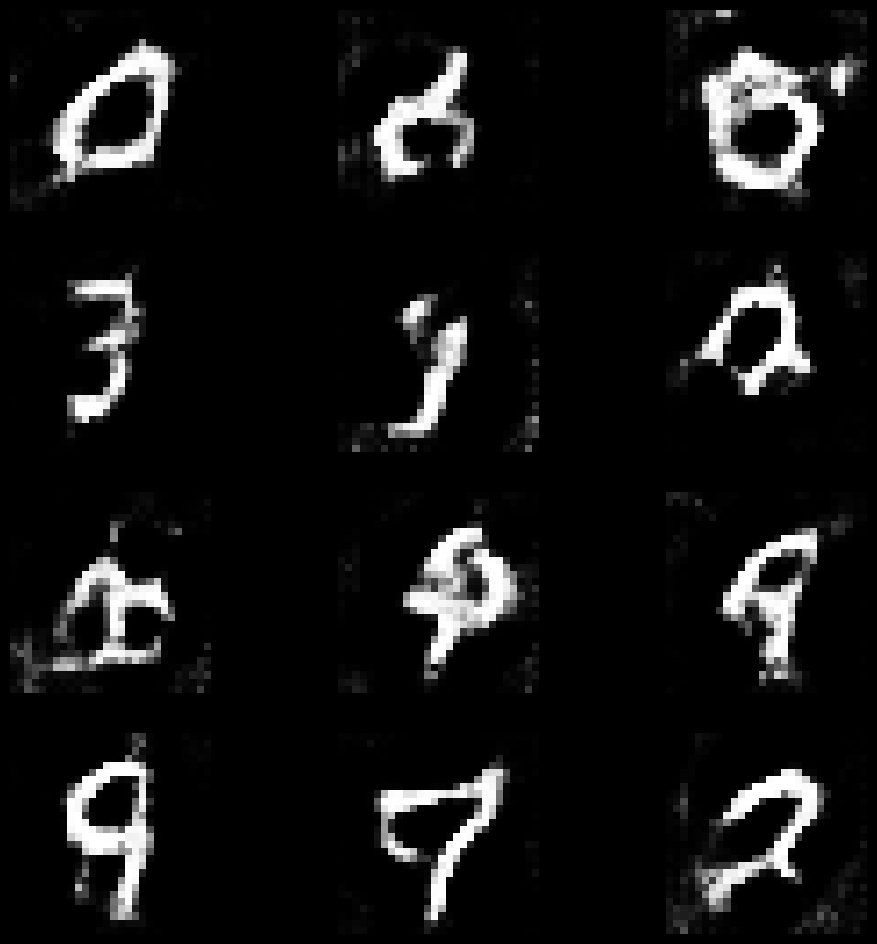

4/4 [==============================] - 0s 4ms/step
epoch:240  D_loss0.54523566365242  Acc:75.78125  G_loss:0.9165881872177124 
1/1 [==============================] - 0s 17ms/step


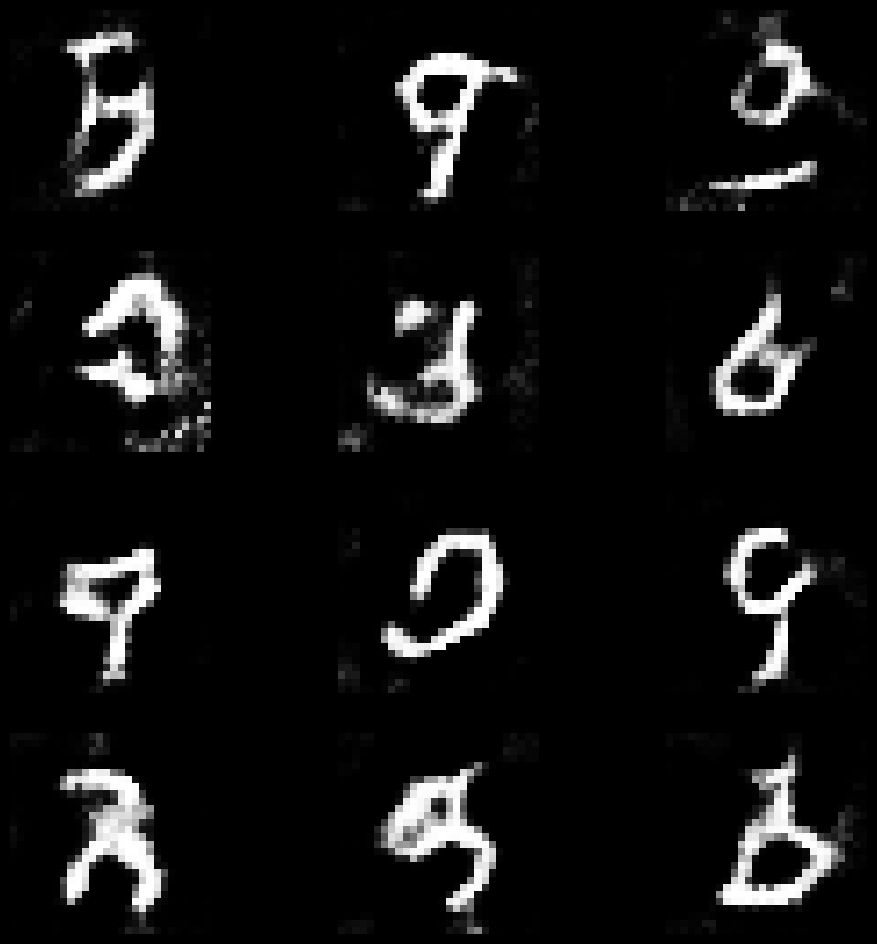

4/4 [==============================] - 0s 5ms/step
epoch:260  D_loss0.633926510810852  Acc:64.0625  G_loss:0.8577299118041992 
1/1 [==============================] - 0s 31ms/step


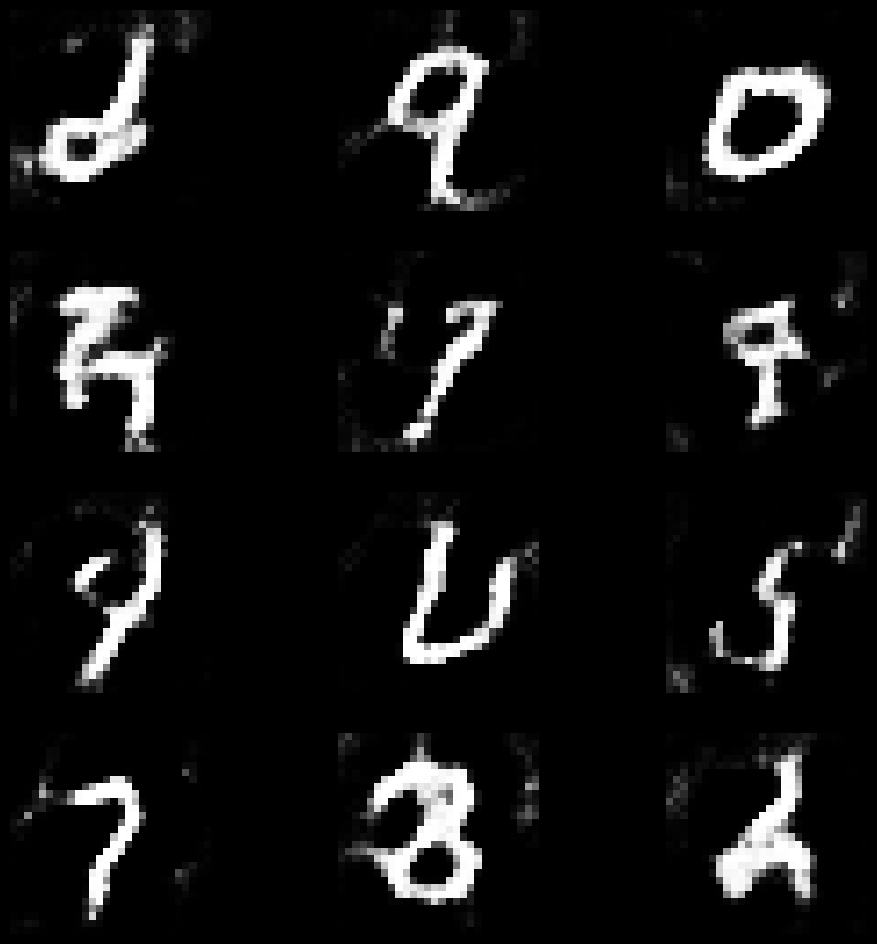

4/4 [==============================] - 0s 7ms/step
epoch:280  D_loss0.5678381621837616  Acc:73.828125  G_loss:0.8517690896987915 
1/1 [==============================] - 0s 19ms/step


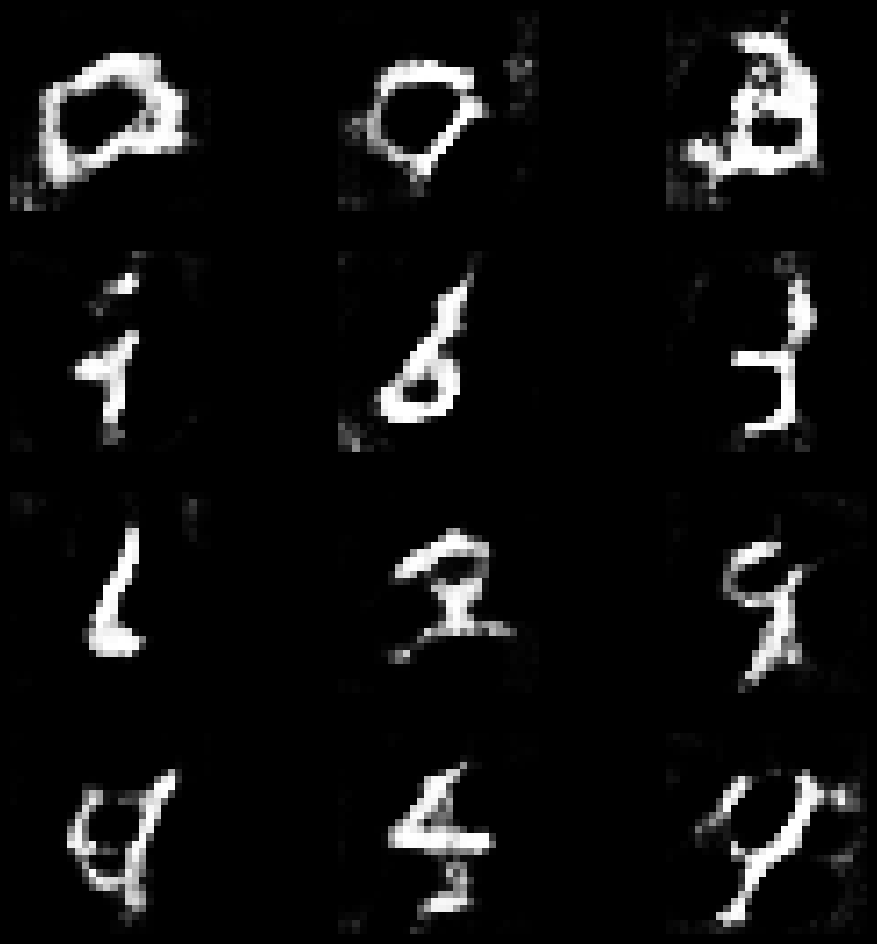

4/4 [==============================] - 0s 6ms/step
epoch:300  D_loss0.537776529788971  Acc:76.953125  G_loss:0.8749515414237976 
1/1 [==============================] - 0s 17ms/step


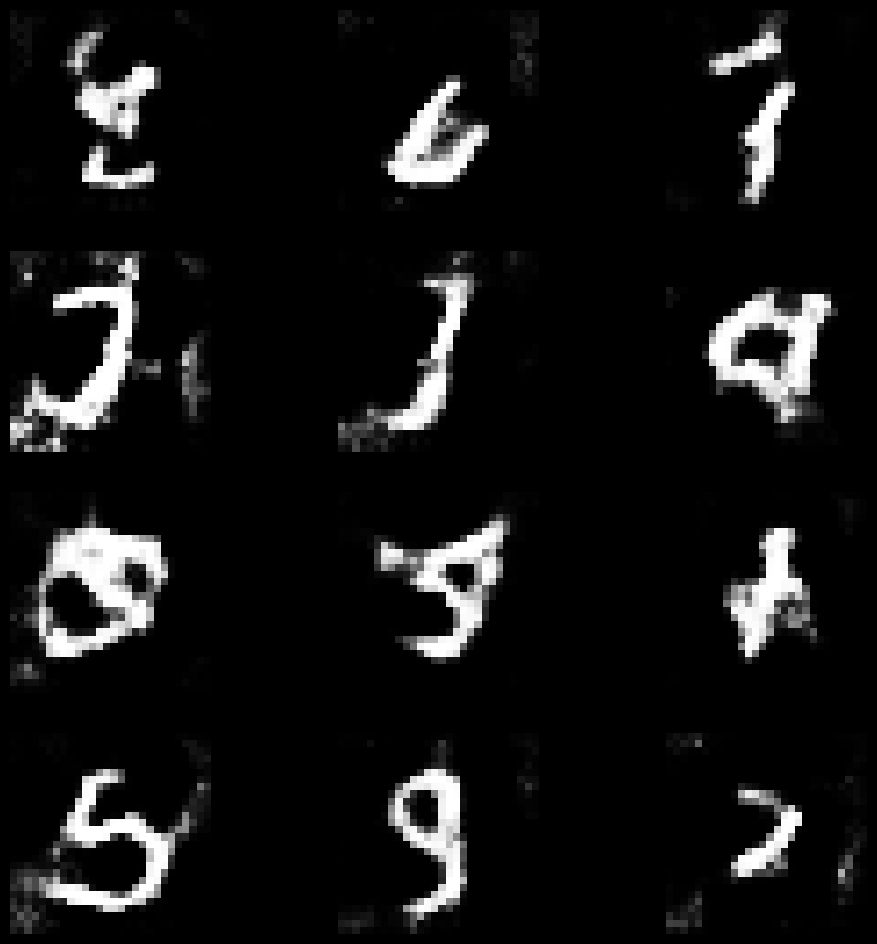

4/4 [==============================] - 0s 6ms/step
epoch:320  D_loss0.4422222822904587  Acc:87.5  G_loss:0.8282938599586487 
1/1 [==============================] - 0s 18ms/step


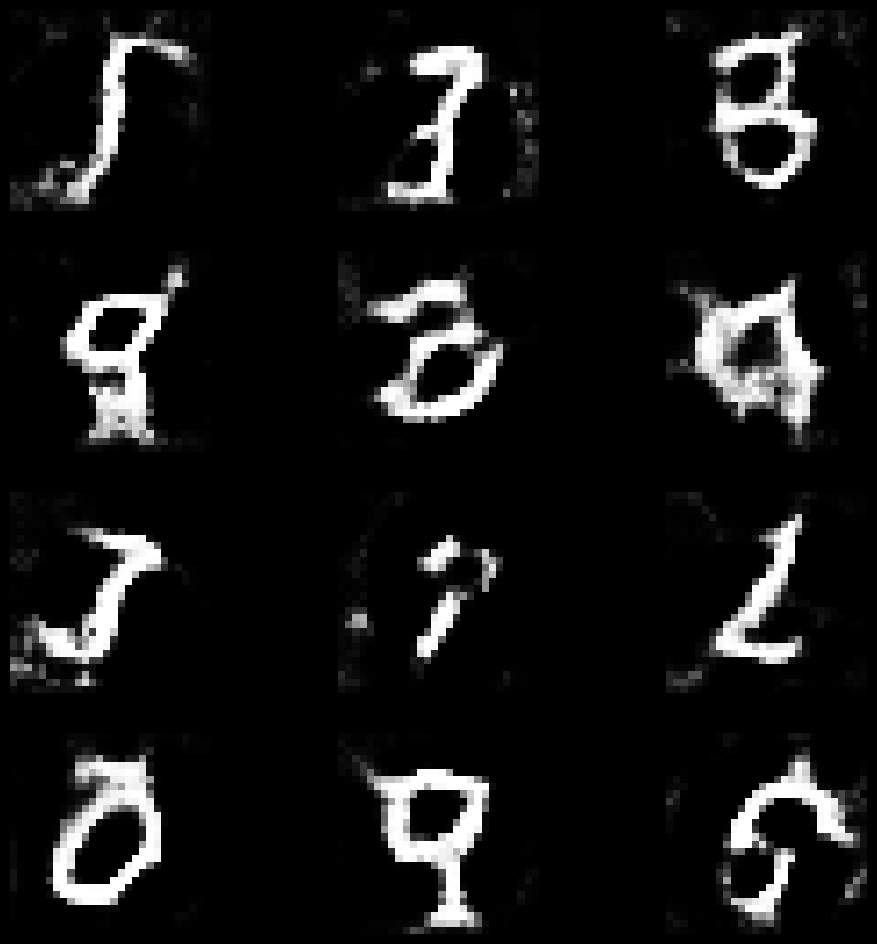

4/4 [==============================] - 0s 5ms/step
epoch:340  D_loss0.483428955078125  Acc:84.765625  G_loss:0.8684607744216919 
1/1 [==============================] - 0s 20ms/step


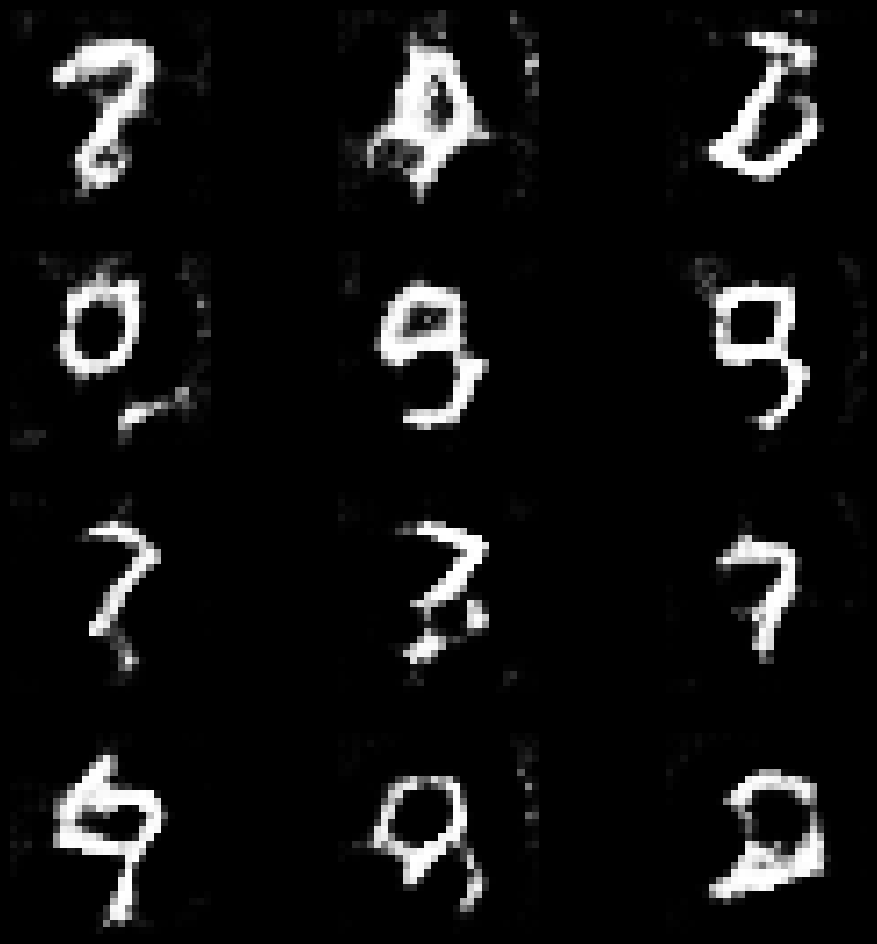

4/4 [==============================] - 0s 5ms/step
epoch:360  D_loss0.5591068267822266  Acc:75.0  G_loss:0.8812872171401978 
1/1 [==============================] - 0s 29ms/step


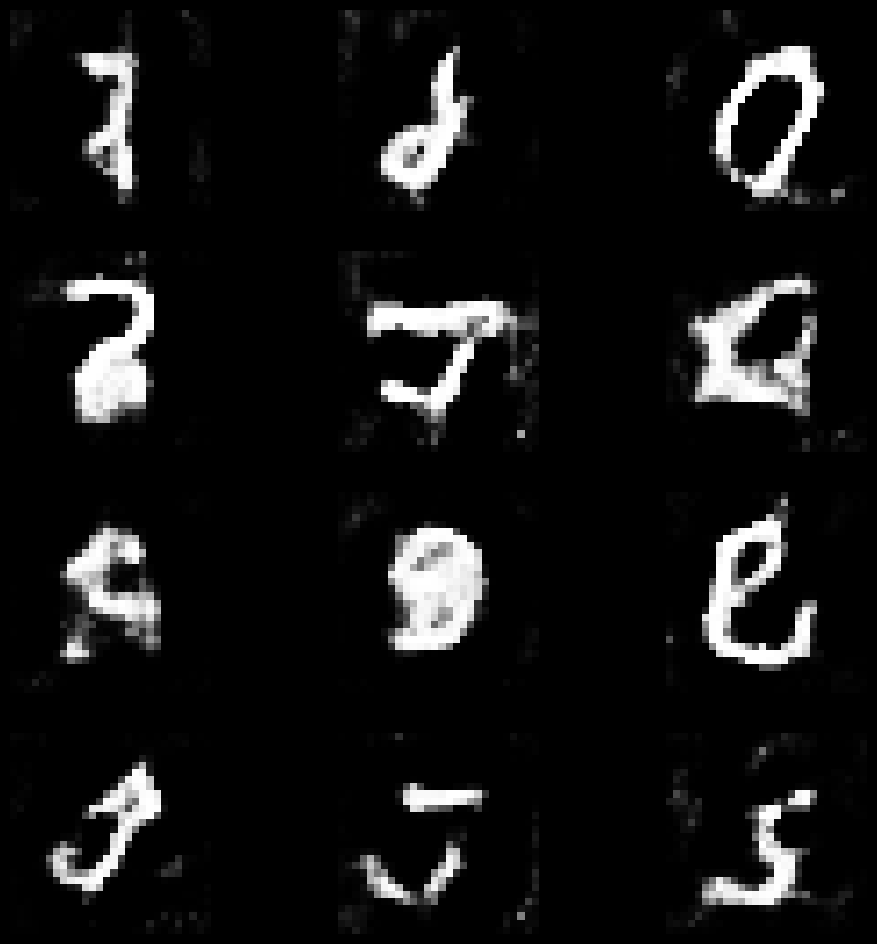

4/4 [==============================] - 0s 8ms/step
epoch:380  D_loss0.48368436098098755  Acc:82.8125  G_loss:0.8478584289550781 
1/1 [==============================] - 0s 17ms/step


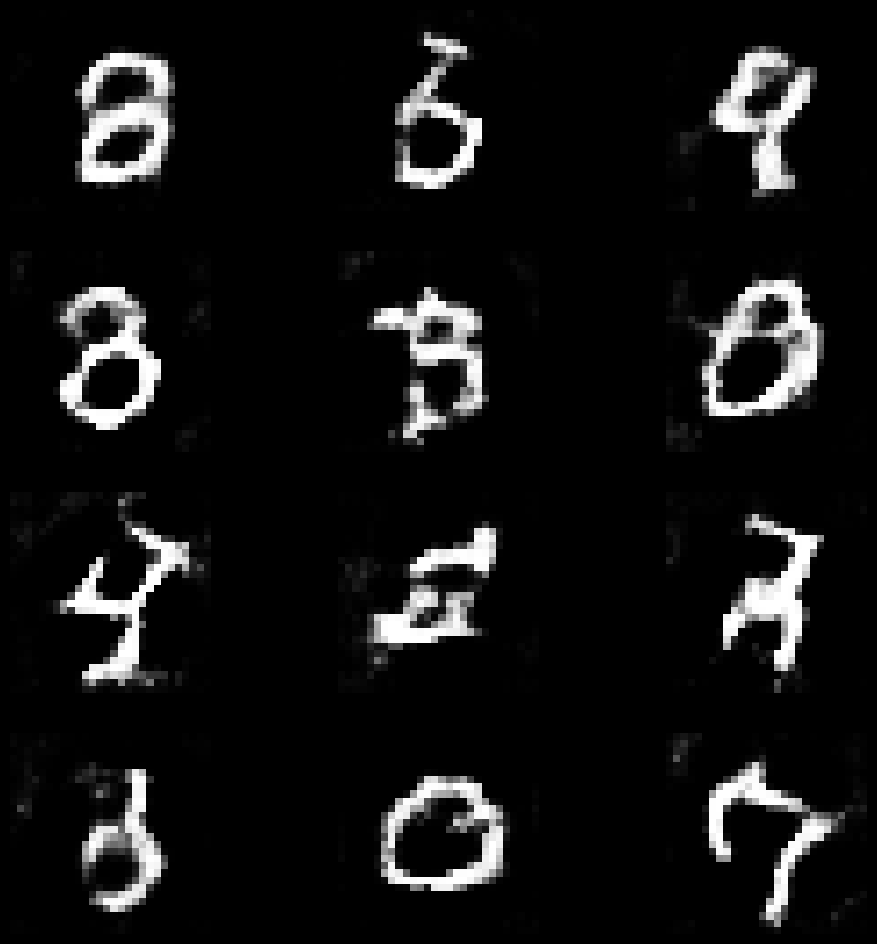

4/4 [==============================] - 0s 4ms/step
epoch:400  D_loss0.5122823417186737  Acc:78.90625  G_loss:0.8146915435791016 
1/1 [==============================] - 0s 18ms/step


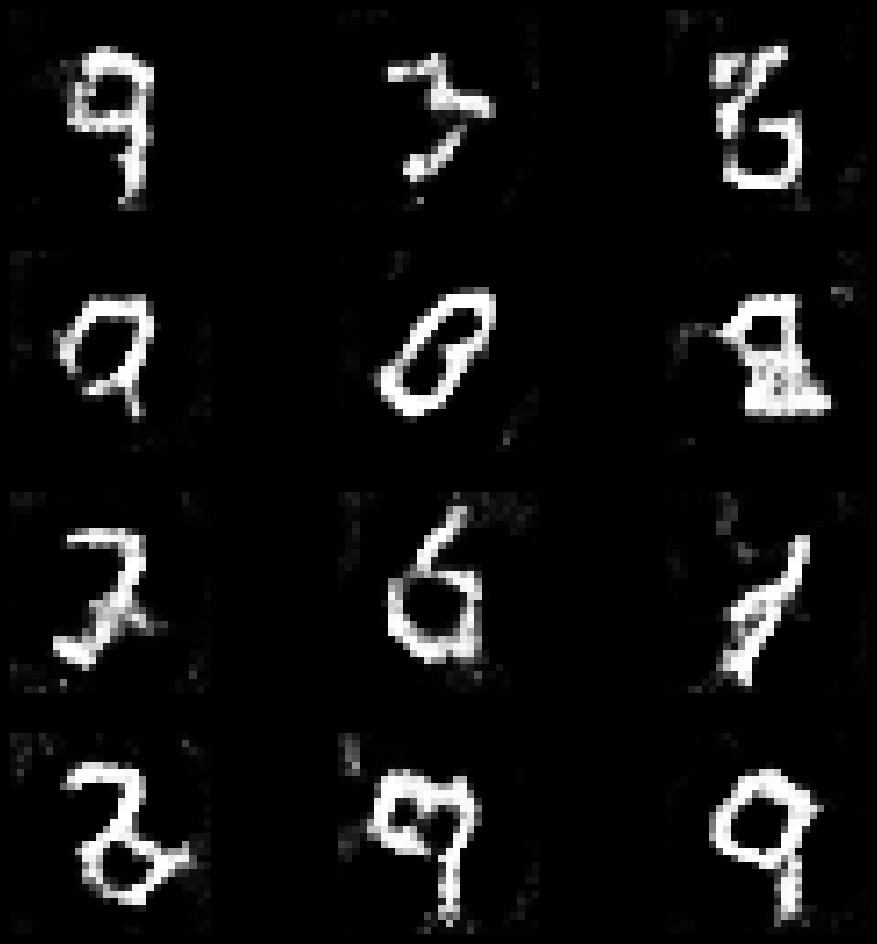

4/4 [==============================] - 0s 7ms/step
epoch:420  D_loss0.5437617003917694  Acc:77.734375  G_loss:0.8980141282081604 
1/1 [==============================] - 0s 41ms/step


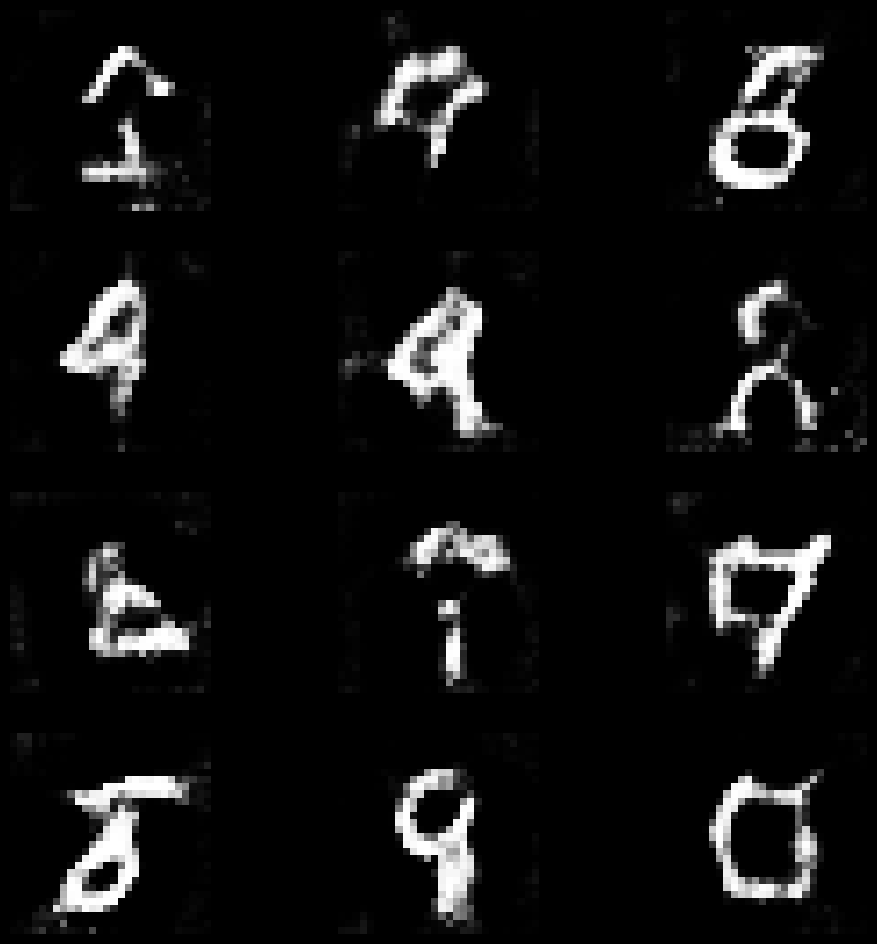

4/4 [==============================] - 0s 4ms/step
epoch:440  D_loss0.45848600566387177  Acc:85.546875  G_loss:0.8823439478874207 
1/1 [==============================] - 0s 19ms/step


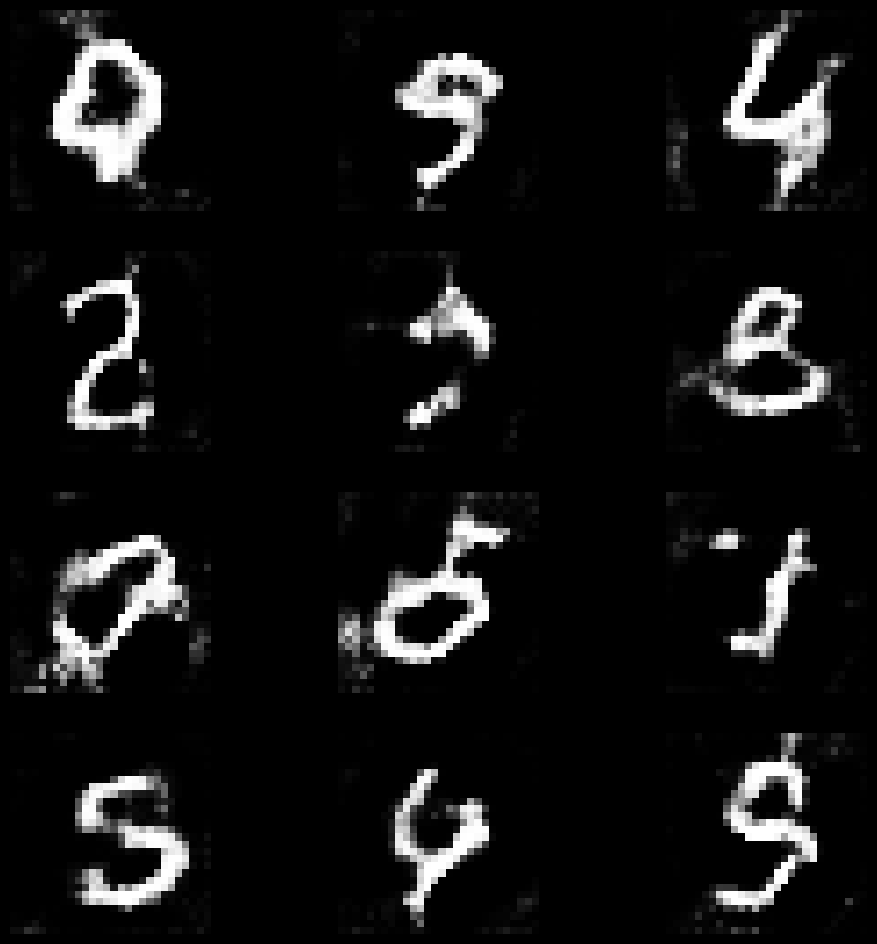

4/4 [==============================] - 0s 5ms/step
epoch:460  D_loss0.4657703638076782  Acc:84.765625  G_loss:0.7953222990036011 
1/1 [==============================] - 0s 18ms/step


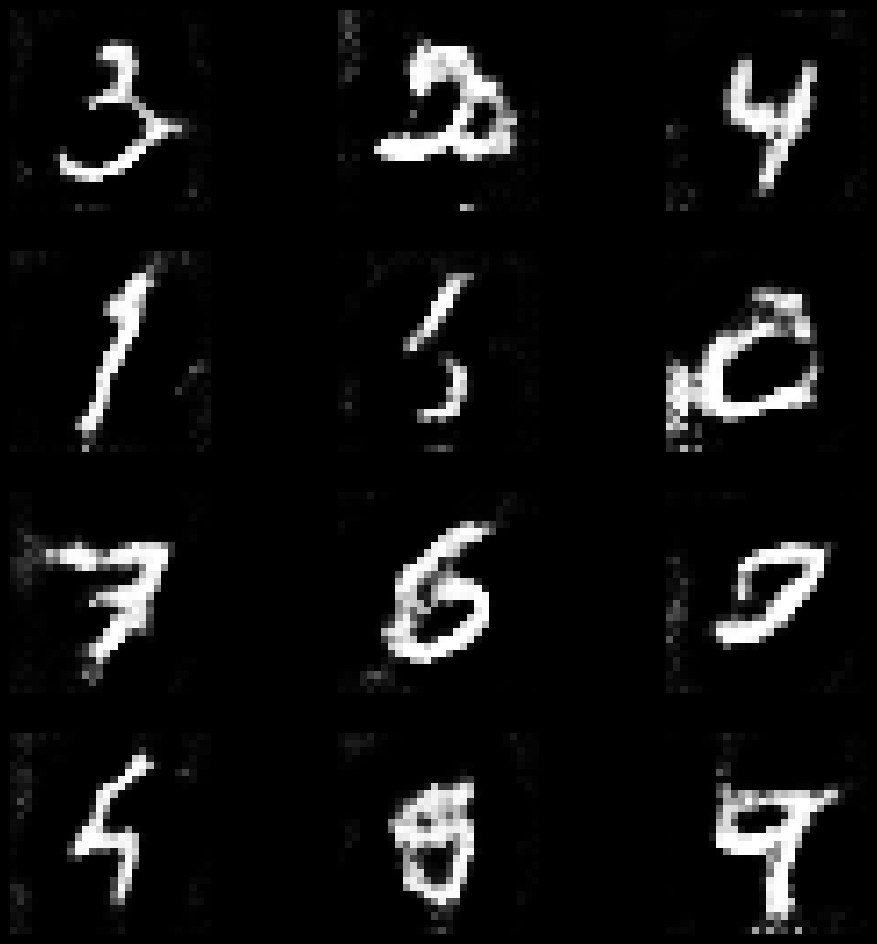

4/4 [==============================] - 0s 7ms/step
epoch:480  D_loss0.38798995316028595  Acc:90.625  G_loss:0.8003419041633606 
1/1 [==============================] - 0s 17ms/step


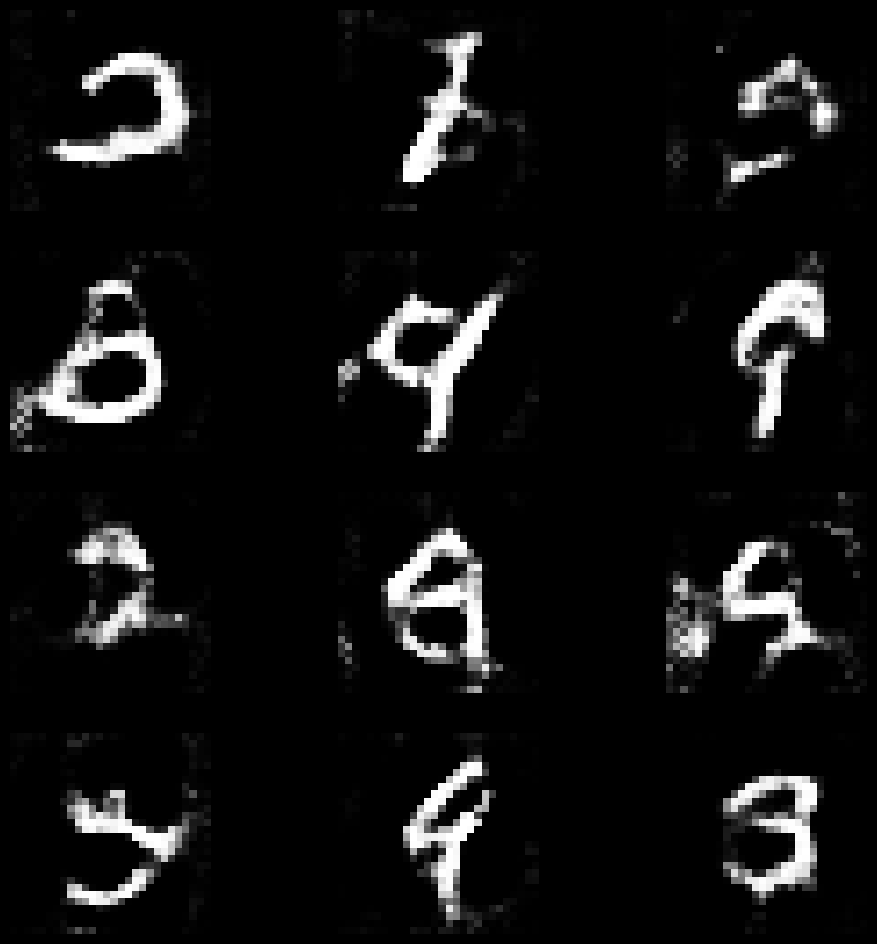

4/4 [==============================] - 0s 4ms/step
epoch:500  D_loss0.46485230326652527  Acc:83.59375  G_loss:0.8908119201660156 
1/1 [==============================] - 0s 24ms/step


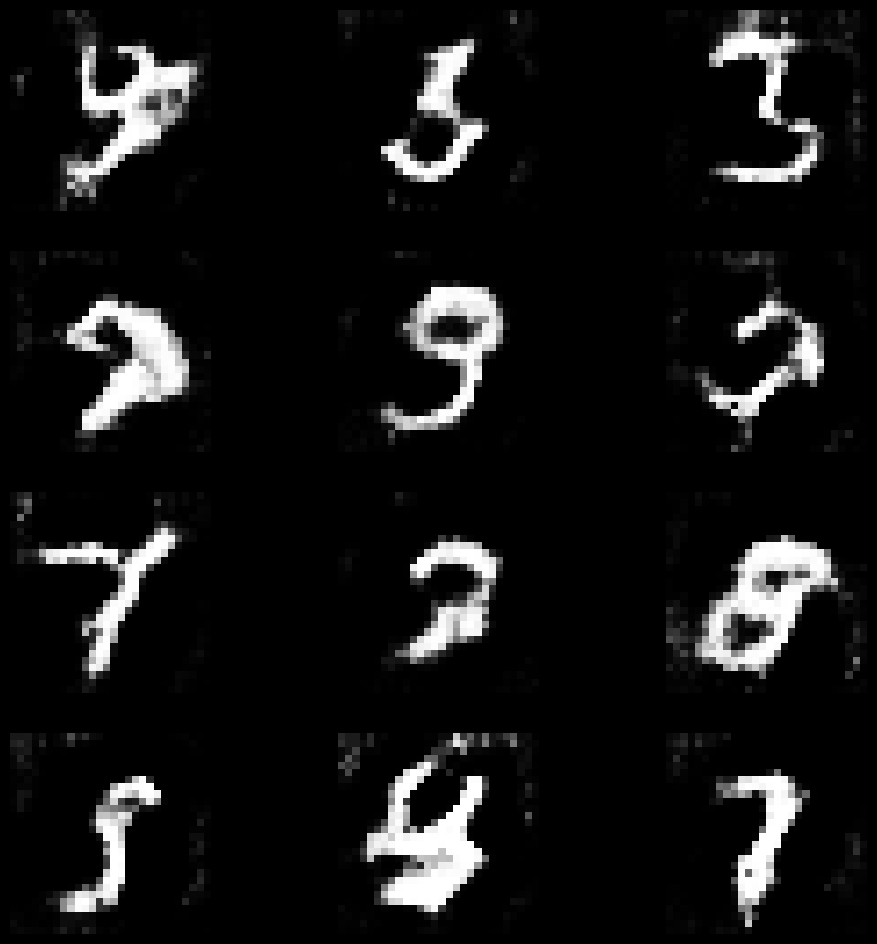

4/4 [==============================] - 0s 7ms/step
epoch:520  D_loss0.3451499044895172  Acc:92.1875  G_loss:0.799724817276001 
1/1 [==============================] - 0s 34ms/step


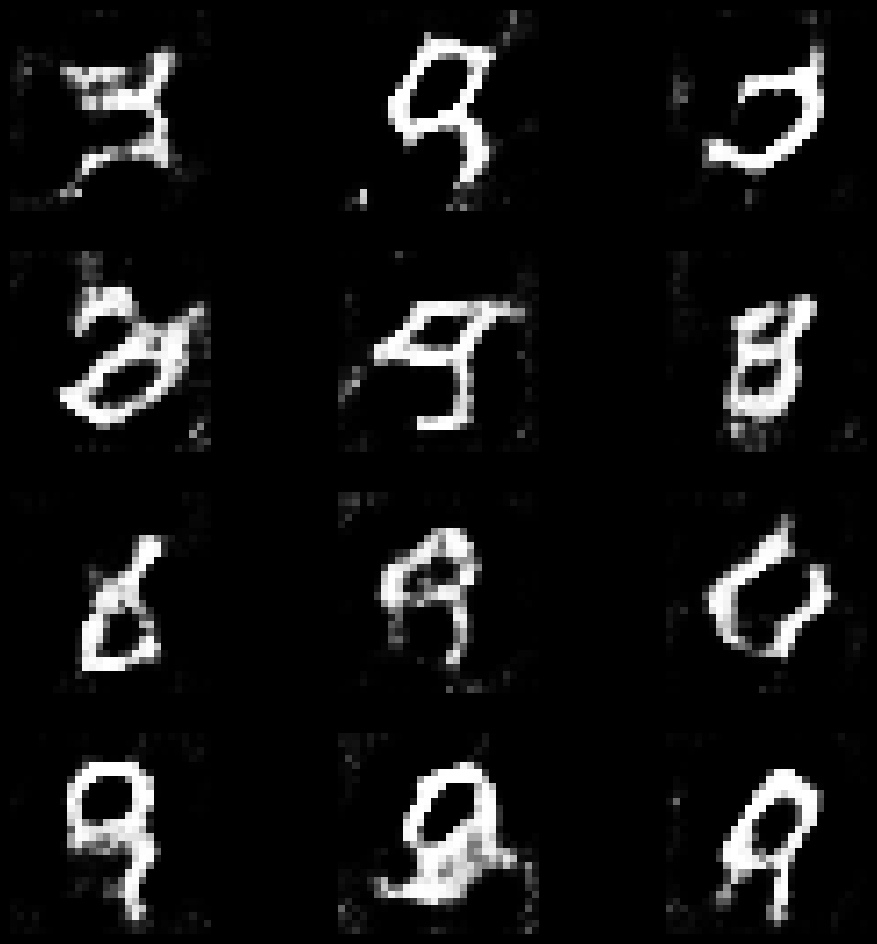

4/4 [==============================] - 0s 5ms/step
epoch:540  D_loss0.4361841082572937  Acc:87.5  G_loss:0.9327907562255859 
1/1 [==============================] - 0s 18ms/step


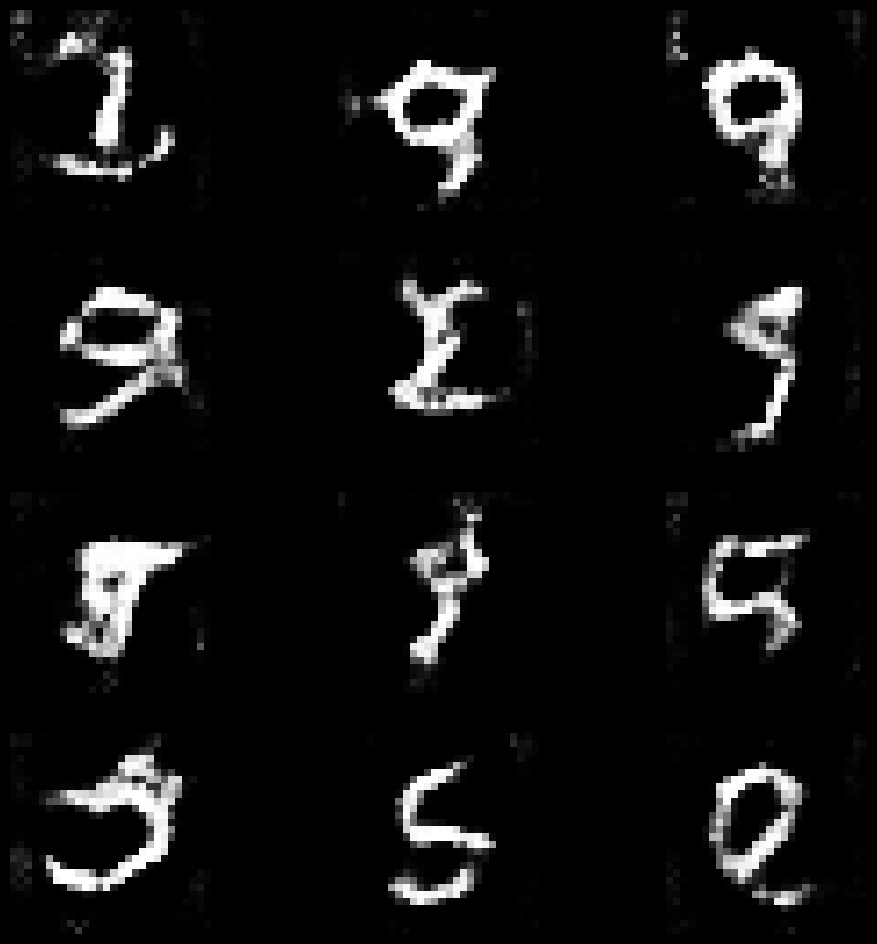

4/4 [==============================] - 0s 4ms/step
epoch:560  D_loss0.40329115092754364  Acc:90.625  G_loss:0.8430030345916748 
1/1 [==============================] - 0s 19ms/step


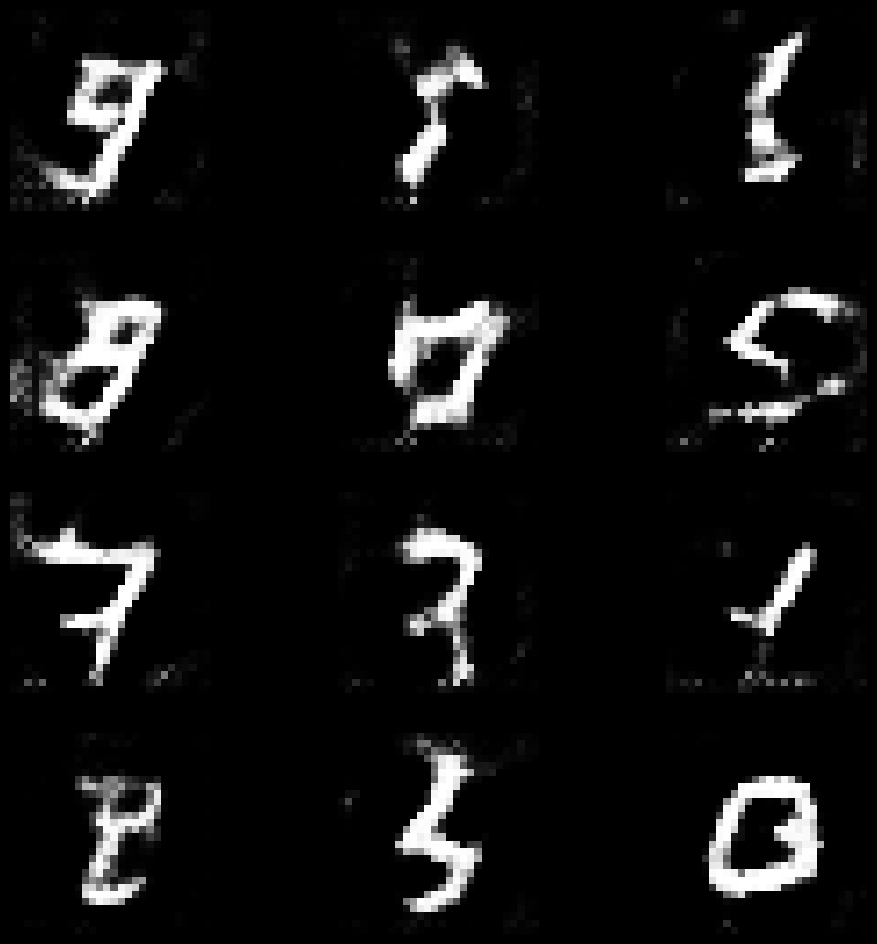

4/4 [==============================] - 0s 7ms/step
epoch:580  D_loss0.3542892336845398  Acc:91.796875  G_loss:1.0221822261810303 
1/1 [==============================] - 0s 31ms/step


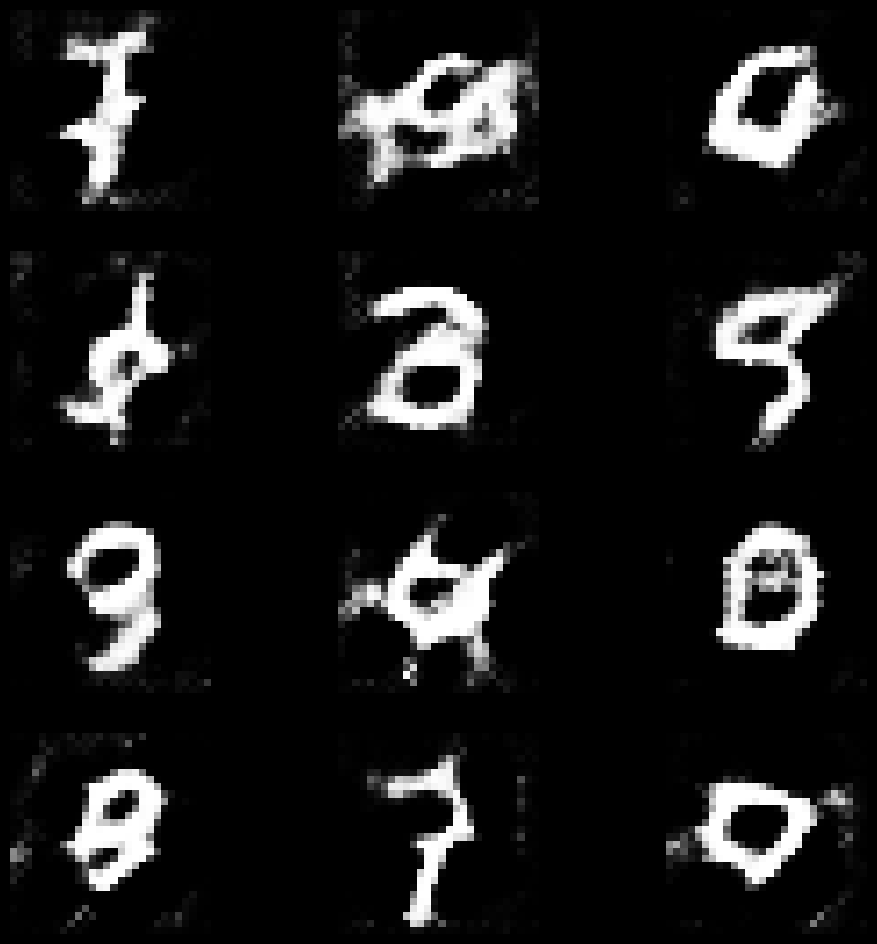

4/4 [==============================] - 0s 8ms/step
epoch:600  D_loss0.27227307856082916  Acc:97.265625  G_loss:0.9028428196907043 
1/1 [==============================] - 0s 21ms/step


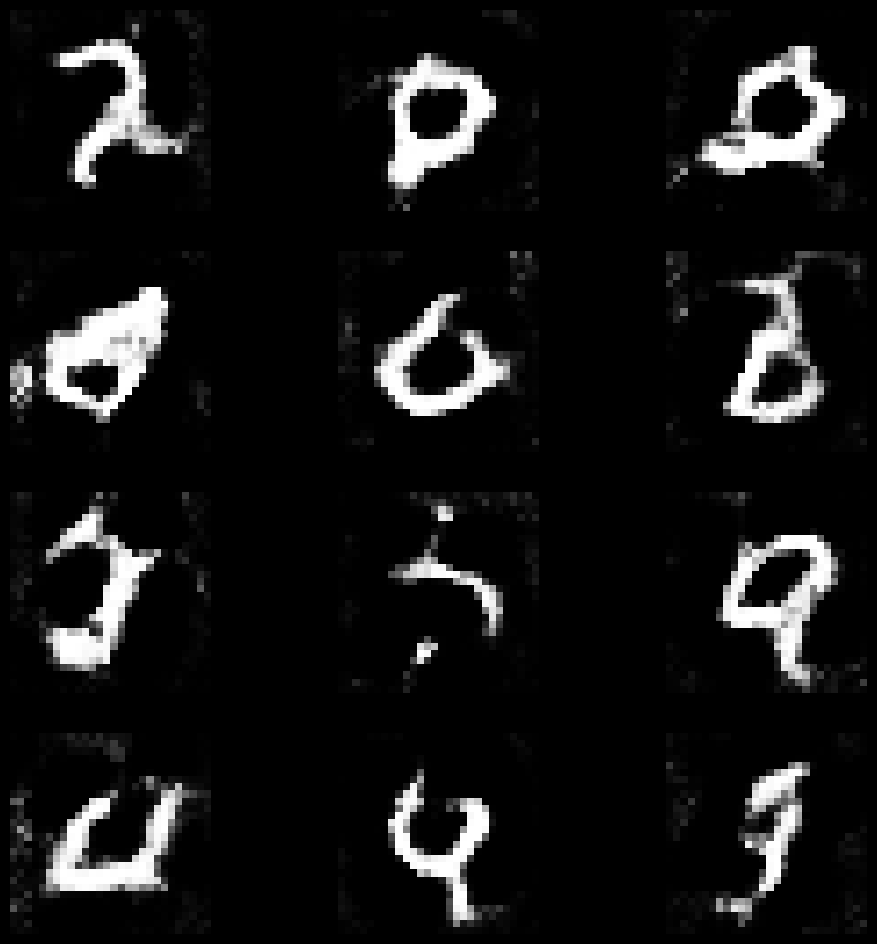

4/4 [==============================] - 0s 5ms/step
epoch:620  D_loss0.25605209916830063  Acc:97.265625  G_loss:0.8248856067657471 
1/1 [==============================] - 0s 21ms/step


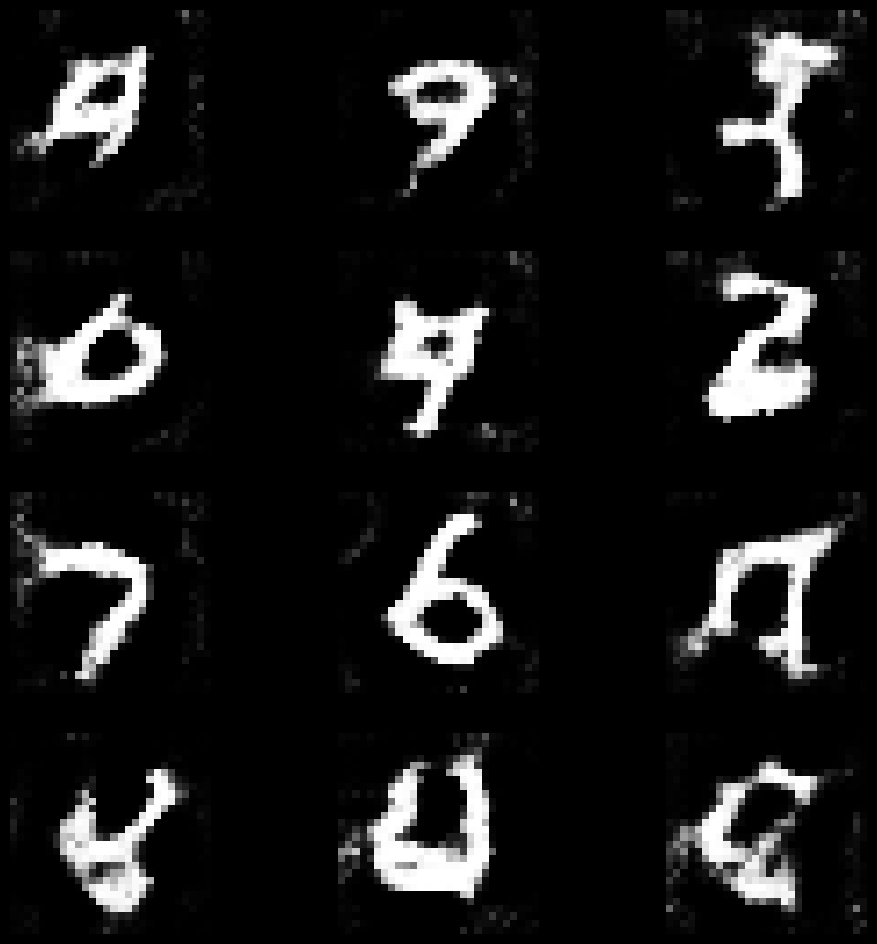

4/4 [==============================] - 0s 5ms/step
epoch:640  D_loss0.27284131944179535  Acc:95.703125  G_loss:0.8820099830627441 
1/1 [==============================] - 0s 23ms/step


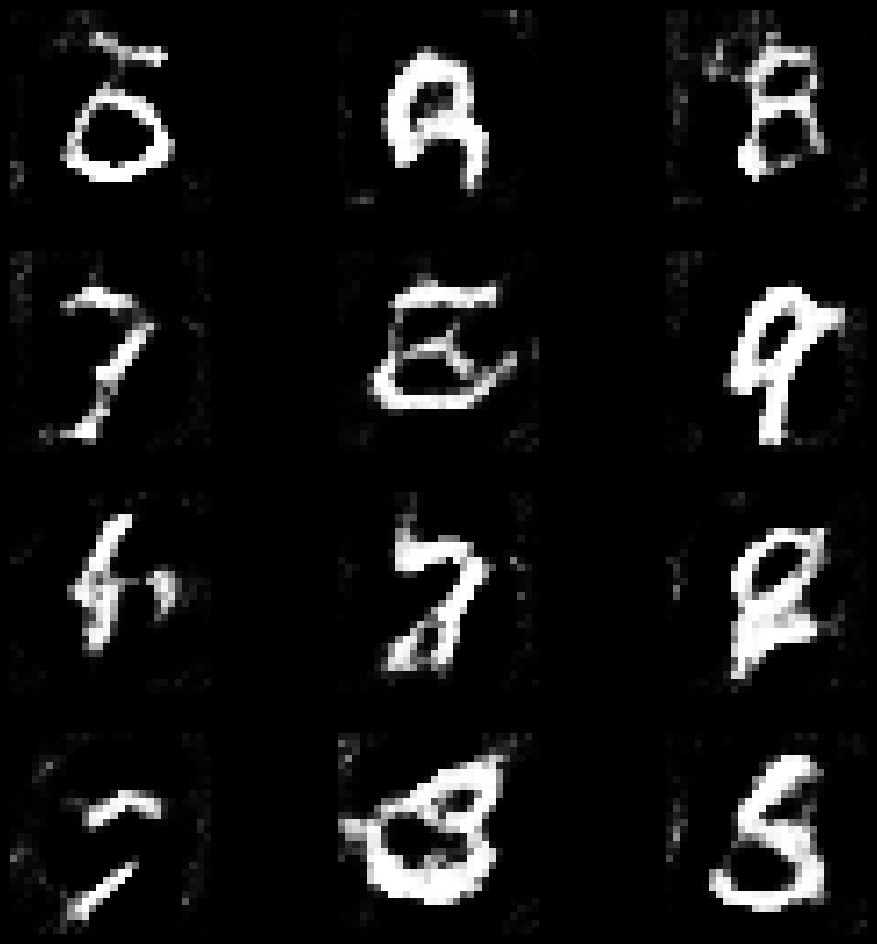

4/4 [==============================] - 0s 4ms/step
epoch:660  D_loss0.18058887124061584  Acc:99.609375  G_loss:0.939408004283905 
1/1 [==============================] - 0s 19ms/step


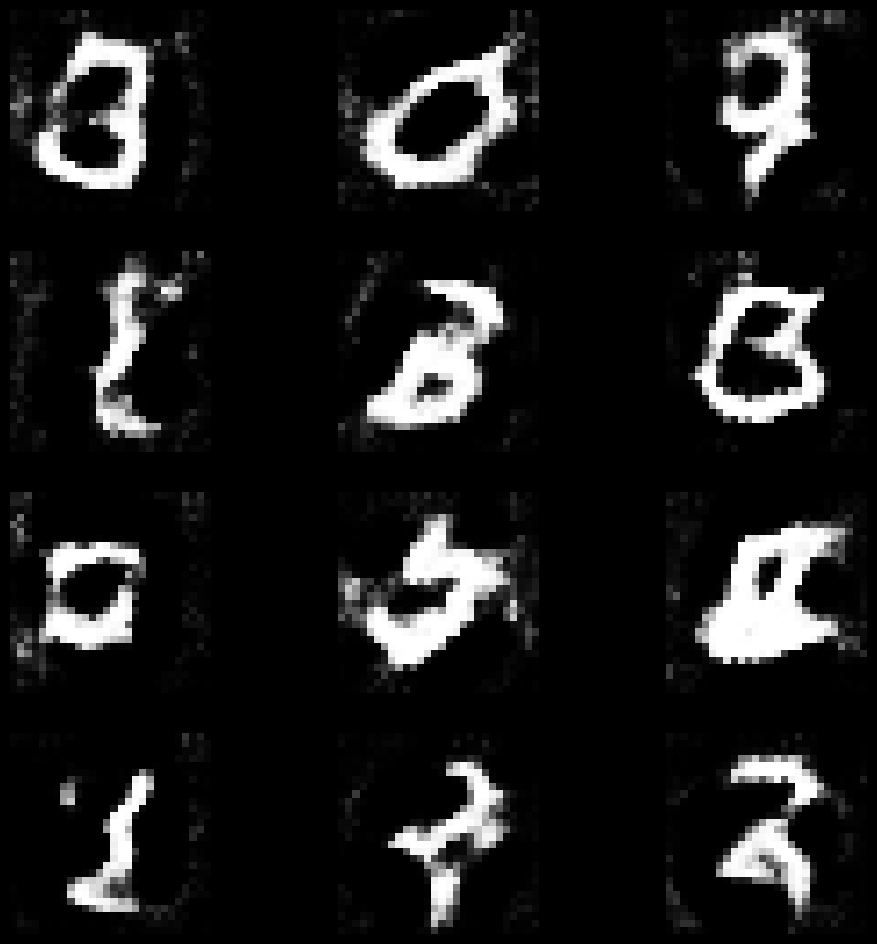

4/4 [==============================] - 0s 4ms/step
epoch:680  D_loss0.3907228261232376  Acc:90.625  G_loss:0.7443030476570129 
1/1 [==============================] - 0s 19ms/step


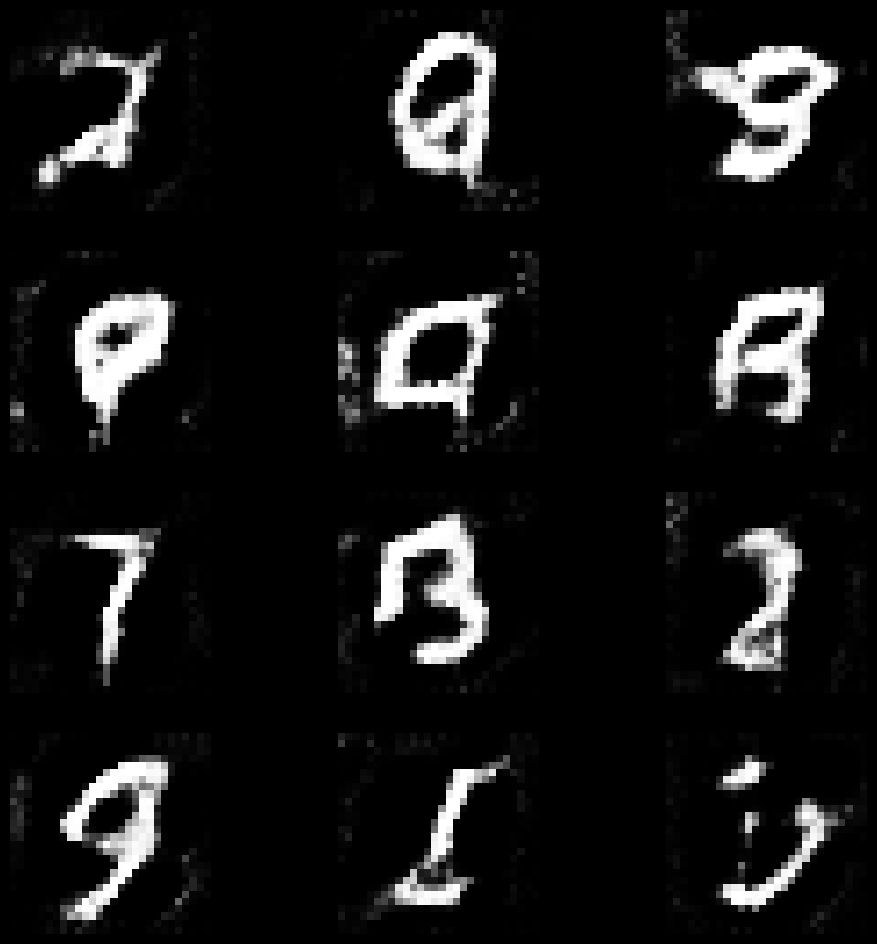

4/4 [==============================] - 0s 4ms/step
elapsed training time: 2 min, 37 sec 


In [199]:
start = time.time()
train(epochs=700,batch_size=128,save_inter=20)
end = time.time()
train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),int((end - start) % 60))
print(train_time)

In [197]:
os.makedirs('saved_model_weights', exist_ok=True)
generator.save_weights('saved_model_weights/generator_weights.h5')
distriminator.save_weights('saved_model_weights/discriminator_weights.h5')
compile.save_weights('saved_model_weights/combined_weights.h5')

4/4 [==============================] - 0s 4ms/step


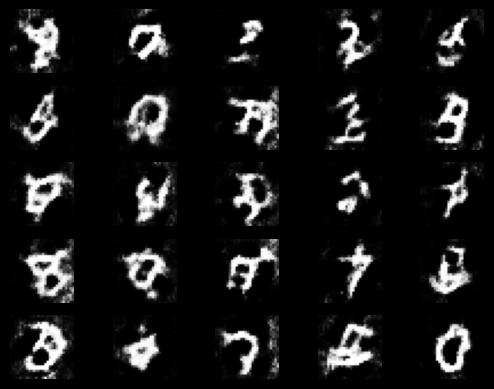

In [198]:
random_vector = np.random.normal(size=(100,100))
generate_image = generator.predict(random_vector)
generate_image = (generate_image + 1)* 127.5
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.imshow(generate_image[i],cmap='gray')
plt.show()